<div style="background-color:#3b5998; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h1 align="center" style="color:#ffffff;"><b>PLANT SEEDLINGS CLASSIFICATION 🔍</b></h1>
</div>

<div style="background-color:#ffffff; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <img src="https://media.tenor.com/q5eSKo33o3wAAAAd/planting-linus-van-pelt.gif" alt="Animated GIF">
</div>

<div style="background-color:#dfe3ee; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#000000;"><b>IMPORT DEPENDENCIES</b></h2>
</div>

In [1]:
!pip3 install -q seaborn tensorflow pillow scikit-learn pydot graphviz


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Standard Libraries
import os
import warnings

# External Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from numpy import array, asarray
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

# TensorFlow and Keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.mobilenet import preprocess_input

# Other Utilities
import base64
from IPython.display import HTML, display

# Set seed and constants
np.random.seed(42)
kf = KFold(n_splits=5)
epochs = 20
batch_size = 32

# Suppress warnings
warnings.filterwarnings("ignore")

<div style="background-color:#dfe3ee; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#000000;"><b>DATA PREPARATION</b></h2>
</div>

In [3]:
pathToTrainData='/kaggle/input/plant-seedlings-classification/train'
pathToTestData ='/kaggle/input/plant-seedlings-classification/test'

training_img_list = list()
testing_img_list  = list()

shape_sum       = 0
class_name_num  = dict()
train_avg_shape = 80

for dirname, _, filenames in os.walk(pathToTrainData):
    for filename in filenames:
        img_data = Image.open(os.path.join(dirname, filename))
        
        resizedImage = img_data.resize((train_avg_shape, train_avg_shape))
        resizedImage = resizedImage.convert('RGB')
        resizedImage = asarray(resizedImage)/255
        
        class_label = dirname.split('/')[-1]
        training_img_list.append([resizedImage, class_label])
        shape_sum += np.max(img_data.size)
        class_name_num[class_label] = len(class_name_num)-1
        

for dirname, _, filenames in os.walk(pathToTestData):
    for filename in filenames:
        img_data = Image.open(os.path.join(dirname, filename))
        
        resizedImage = img_data.resize((train_avg_shape, train_avg_shape))
        resizedImage = resizedImage.convert('RGB')
        resizedImage = asarray(resizedImage)/255

        testing_img_list.append([resizedImage,filename])

X_test = np.zeros((len(testing_img_list), train_avg_shape, train_avg_shape, 3), dtype='float32')
for i,img in enumerate(testing_img_list):
    X_test[i] = testing_img_list[i][0]

<div style="background-color:#dfe3ee; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#000000;"><b>BUILD/TRAIN MODEL</b></h2>
</div>

In [4]:
VGG19_MODEL = VGG19(weights='imagenet', include_top=False)
# Specify the path to save the plot
plot_path = '/kaggle/working/VGG19Original.png'
# Save the plot to the specified path
plot_model(VGG19_MODEL, to_file=plot_path, show_shapes=True, show_layer_names=True)
# Check if the file exists before reading
if os.path.exists(plot_path):
    with open(plot_path, "rb") as img_file:
        img_data = img_file.read()
    img_base64 = base64.b64encode(img_data).decode("utf-8")

    html_code = f'''
    <div style="background-color:white; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center;">
        <img src="data:image/png;base64,{img_base64}" style="display: block; margin: 0 auto;">
    </div>
    '''
    display(HTML(html_code))
else:
    print(f"Error: File '{plot_path}' not found.")

2023-11-21 07:56:43.115536: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-21 07:56:43.115658: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-21 07:56:43.115744: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-21 07:56:43.115822: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-21 07:56:43.115890: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-21 07:56:43.116113: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-21 07:56:43.116210: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

80134624/80134624 [==============================] - 0s 0us/step
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Error: File '/kaggle/working/VGG19Original.png' not found.


In [5]:
VGG19_MODEL.summary();

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [6]:
print(f"VGG19 Model Layers Count :{len(VGG19_MODEL.layers)}");

VGG19 Model Layers Count :22


In [7]:
x=VGG19_MODEL.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(len(class_name_num), activation='softmax')(x) #final layer with softmax activation

In [8]:
NewModel=Model(inputs=VGG19_MODEL.input,outputs=preds)
NewModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [9]:
print(f"New Model layers count :{len(NewModel.layers)}")

New Model layers count :27


In [10]:
for layer in NewModel.layers[:-5]:
    layer.trainable=False

NewModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [11]:
plot_path = '/kaggle/working/NewModel.png'
# Save the plot to the specified path
plot_model(NewModel, to_file=plot_path, show_shapes=True, show_layer_names=True)
# Check if the file exists before reading
if os.path.exists(plot_path):
    with open(plot_path, "rb") as img_file:
        img_data = img_file.read()
    img_base64 = base64.b64encode(img_data).decode("utf-8")

    html_code = f'''
    <div style="background-color:white; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center;">
        <img src="data:image/png;base64,{img_base64}" style="display: block; margin: 0 auto;">
    </div>
    '''
    display(HTML(html_code))
else:
    print(f"Error: File '{plot_path}' not found.")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Error: File '/kaggle/working/NewModel.png' not found.


In [12]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=train_datagen.flow_from_directory(
    pathToTrainData,
    target_size=(80,80),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
);

Found 4750 images belonging to 12 classes.


In [13]:
NewModel.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size
history = NewModel.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,epochs=10);

Epoch 1/10
148/148 [==============================] - 56s 370ms/step - loss: 1.5852 - accuracy: 0.4400
Epoch 2/10
148/148 [==============================] - 58s 389ms/step - loss: 1.1002 - accuracy: 0.6041
Epoch 3/10
148/148 [==============================] - 54s 363ms/step - loss: 0.9181 - accuracy: 0.6761
Epoch 4/10
148/148 [==============================] - 54s 365ms/step - loss: 0.8136 - accuracy: 0.7100
Epoch 5/10
148/148 [==============================] - 54s 361ms/step - loss: 0.7076 - accuracy: 0.7471
Epoch 6/10
148/148 [==============================] - 54s 366ms/step - loss: 0.6646 - accuracy: 0.7594
Epoch 7/10
148/148 [==============================] - 54s 364ms/step - loss: 0.5679 - accuracy: 0.7961
Epoch 8/10
148/148 [==============================] - 54s 366ms/step - loss: 0.5406 - accuracy: 0.8056
Epoch 9/10
148/148 [==============================] - 54s 367ms/step - loss: 0.4627 - accuracy: 0.8353
Epoch 10/10
148/148 [==============================] - 54s 366ms/step - l


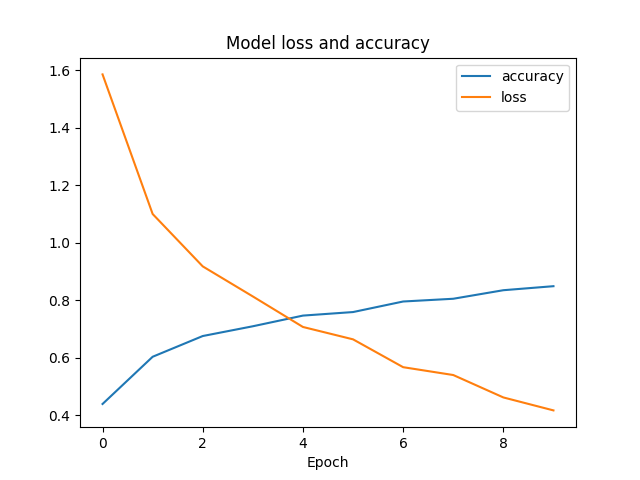

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model loss and accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy','loss'], loc='upper right')
plt.savefig('combined_plot.png')
plt.close()
with open("combined_plot.png", "rb") as img_file:
    img_data = img_file.read()
img_base64 = base64.b64encode(img_data).decode("utf-8")
html_code = f'''
<div style="background-color:white; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center;">
    <img src="data:image/png;base64,{img_base64}" style="display: block; margin: 0 auto;">
</div>
'''
display(HTML(html_code))

<div style="background-color:#dfe3ee; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#000000;"><b>EVALUATE MODEL</b></h2>
</div>

In [15]:
predictions = NewModel.predict(
    X_test,
    batch_size=None,
    verbose=0,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

predictions=pd.DataFrame(predictions)

In [16]:
inverse_label_map = dict()
for k,v in train_generator.class_indices.items():
    inverse_label_map[v] = k

In [17]:
pred_label_num = predictions.idxmax(axis=1)
pred_label_num_new = list()

for x in pred_label_num:
    y = inverse_label_map[x]
    pred_label_num_new.append(y)

pred_label_num_new = pd.DataFrame(pred_label_num_new)
print(pred_label_num_new[0])

0      Loose Silky-bent
1          Common wheat
2              Cleavers
3              Cleavers
4               Fat Hen
             ...       
789             Fat Hen
790         Black-grass
791            Cleavers
792            Cleavers
793               Maize
Name: 0, Length: 794, dtype: object


In [18]:
testImages = pd.DataFrame(testing_img_list)
pred=pd.DataFrame()
pred["file"] = testImages[1]
pred["species"] = pred_label_num_new[0]
pred.head()

,file,species
0,fd87b36ae.png,Loose Silky-bent
1,0e8492cb1.png,Common wheat
2,8d6acbe9b.png,Cleavers
3,54b3afd58.png,Cleavers
4,6049234e6.png,Fat Hen


In [19]:
pred.to_csv('submission.csv',index = None, header=True)